In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

In [2]:
df = pd.read_csv('./avalanche_dataset_cleaned.csv')
data = df.iloc[:,range(5,15)]
#print (data)

In [3]:
data.head()
feature_cols = ['mean displacement', 'rg', 'shape', 'density', 'clique number', 'average clustering',
               'mean closeness','mean betweenness', 'assortativity']

# feature_cols = ['mean displacement', 'density', 'clique number', 'average clustering',
#                 'mean closeness','mean betweenness', 'assortativity']

# feature_cols = [ 'density', 'clique number', 'average clustering',
#                 'mean closeness','mean betweenness', 'assortativity']

# feature_cols = ['mean displacement', 'rg', 'shape']

# feature_cols = ['mean displacement', 'shape']

X = data[feature_cols]
y = data.avalanche

# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4 ,random_state=25)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [4]:
X_train.to_csv(r'./X_train.csv', index = False)
y_train.to_csv(r'./y_train.csv', index = False)

In [5]:
X_test.to_csv(r'./X_test.csv', index = False)
y_test.to_csv(r'./y_test.csv', index = False)

In [6]:
import xgboost as xgb

#convert dataset to the format that xgboost accepts
D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)

In [7]:
#set parameters and steps for the xgboost model
param = {
    'eta': 0.3, 
    'max_depth': 5,  
    'objective': 'multi:softprob',  
    'num_class': 2,
    'num_parallel_tree': 3} 

steps = 50  # The number of training iterations

In [8]:

#train the model
model = xgb.train(param, D_train, steps)

[17:38:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [9]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

preds = model.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(y_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(y_test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(y_test, best_preds)))

Precision = 0.9073359825463612
Recall = 0.8970342522974102
Accuracy = 0.9063444108761329


[[187  11]
 [ 20 113]]


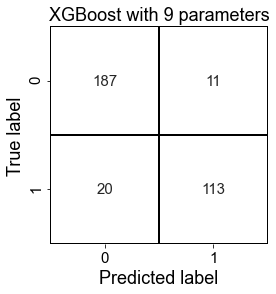

In [17]:
from sklearn import metrics

cm1 = metrics.confusion_matrix(y_test, best_preds)
print (cm1)

ax= plt.subplot()
sns.heatmap(cm1, annot=True,fmt='g',cmap=ListedColormap(['white']),cbar=None, ax = ax, square=True,linewidths=0.5, linecolor='black')
# labels, title and ticks
ax.set_xlabel('Predicted label',fontsize=18);ax.set_ylabel('True label',fontsize=18); 
ax.set_title('XGBoost with 9 parameters'); 
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']);

font = {'family' : 'Arial',
        'weight' : 'light',
        'size'   : 16}

mpl.rc('font', **font)


plt.savefig('./confusion_matrix_xgboost_9_parameters.png',dpi=1000, bbox_inches = "tight")
plt.show()

*Plot ROC and AUC*

In [11]:
# train a logistic regression model on the training set
from sklearn import svm

classifier = svm.SVC(kernel='poly',gamma=0.1,probability=True)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

from sklearn import metrics

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(y_test, y_pred)))

Classification report for classifier SVC(gamma=0.1, kernel='poly', probability=True):
              precision    recall  f1-score   support

           0       0.79      0.92      0.85       198
           1       0.84      0.65      0.73       133

    accuracy                           0.81       331
   macro avg       0.82      0.78      0.79       331
weighted avg       0.81      0.81      0.80       331




[[182  16]
 [ 47  86]]


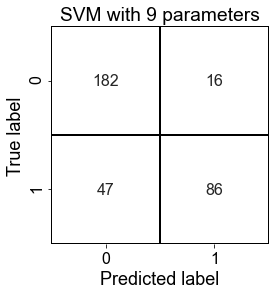

In [12]:
from sklearn import metrics

cm2 = metrics.confusion_matrix(y_test, y_pred)
print (cm2)

ax= plt.subplot()
sns.heatmap(cm2, annot=True,fmt='g',cmap=ListedColormap(['white']),cbar=None, ax = ax, square=True, linewidths=0.5, linecolor='black')
# labels, title and ticks
ax.set_xlabel('Predicted label',fontsize=18);ax.set_ylabel('True label',fontsize=18); 
ax.set_title('SVM with 9 parameters'); 
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']);

font = {'family' : 'Arial',
        'weight' : 'light',
        'size'   : 16}

mpl.rc('font', **font)


plt.savefig('./confusion_matrix_SVM_9_parameters.png',dpi=1000, bbox_inches = "tight")
plt.show()

xgboost: ROC AUC=0.964
SVM: ROC AUC=0.883


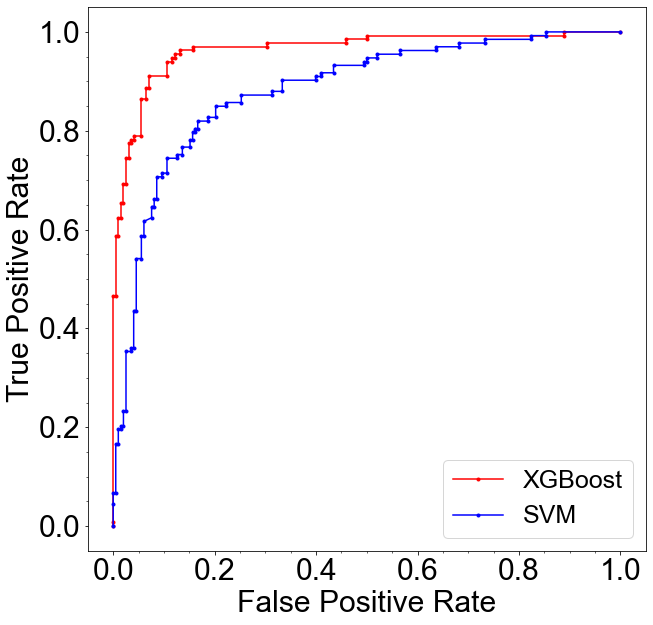

In [13]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#xgboost
xgb_probs = model.predict(D_test)
# keep probabilities for the positive outcome only
xgb_probs = xgb_probs[:, 1]
# calculate scores
xgb_auc = roc_auc_score(y_test, xgb_probs)
# summarize scores
print('xgboost: ROC AUC=%.3f' % (xgb_auc))
# calculate roc curves
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)

#SVM
svm_probs = classifier.predict_proba(X_test)
# keep probabilities for the positive outcome only
svm_probs = svm_probs[:, 1]
# calculate scores
svm_auc = roc_auc_score(y_test, svm_probs)
# summarize scores
print('SVM: ROC AUC=%.3f' % (svm_auc))
# calculate roc curves
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_probs)


# plot the roc curve for the model
mpl.rc('font',family='Arial')
plt.figure(figsize=(10,10))
plt.tick_params(labelsize=30)
plt.plot(xgb_fpr, xgb_tpr, marker='.',label='XGBoost',color='red')
plt.plot(svm_fpr, svm_tpr, marker='.',label='SVM',color='blue')
# axis labels
plt.minorticks_on()
plt.xlabel('False Positive Rate',fontsize=30)
plt.ylabel('True Positive Rate',fontsize=30)
# show the legend
plt.legend(fontsize=25)
# show the plot
plt.savefig('./ROC_AUC_xgboost&SVM_9_parameters.png',dpi=1000)
plt.show()

xgboost: PR AUC=0.955
SVM: PR AUC=0.832


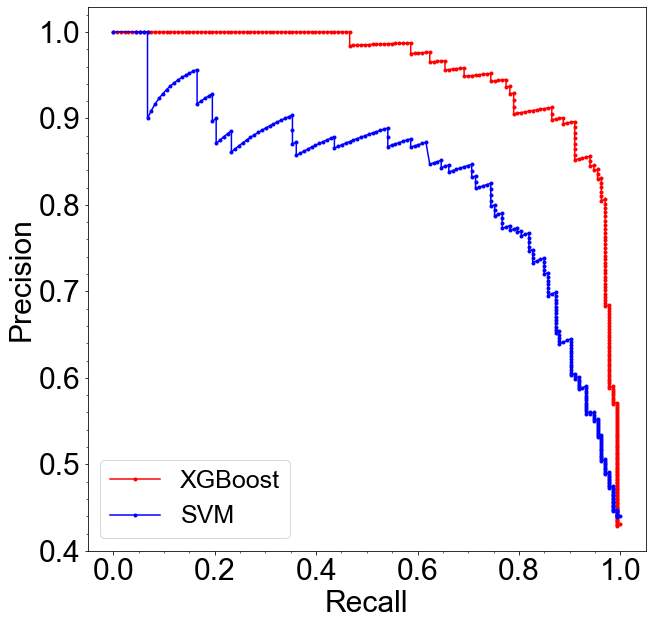

In [14]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

#xgboost
xgb_probs = model.predict(D_test)
# keep probabilities for the positive outcome only
xgb_probs = xgb_probs[:, 1]
# predict class values
yhat = model.predict(D_test)
xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, xgb_probs)
xgb_auc = auc(xgb_recall, xgb_precision)
# summarize scores
print('xgboost: PR AUC=%.3f' % (xgb_auc))

#SVM
svm_probs = classifier.predict_proba(X_test)
# keep probabilities for the positive outcome only
svm_probs = svm_probs[:, 1]
# predict class values
yhat = classifier.predict(X_test)
svm_precision, svm_recall, _ = precision_recall_curve(y_test, svm_probs)
svm_auc = auc(svm_recall, svm_precision)
# summarize scores
print('SVM: PR AUC=%.3f' % (svm_auc))

# plot the precision-recall curves
mpl.rc('font',family='Arial')
plt.figure(figsize=(10,10))
plt.tick_params(labelsize=30)
plt.plot(xgb_recall, xgb_precision, marker='.',label='XGBoost',color='red')
plt.plot(svm_recall, svm_precision, marker='.',label='SVM',color='blue')
# axis labels
plt.minorticks_on()
plt.xlabel('Recall',fontsize=30)
plt.ylabel('Precision',fontsize=30)
# show the legend
plt.legend(fontsize=25)
# show the plot
plt.savefig('./PR_AUC_xgboost&SVM_9_parameters.png',dpi=1000)
plt.show()

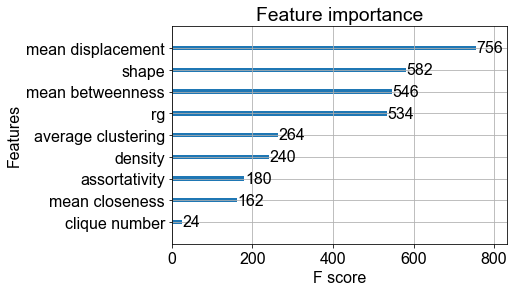

In [15]:
xgb.plot_importance(model)
# plt.tick_params(labelsize=10)

font = {'family' : 'Arial',
        'weight' : 'light',
        'size'   : 15}

mpl.rc('font', **font)



plt.savefig('./xgboost_importance_9_parameters',dpi=1000, bbox_inches = "tight")
plt.show()

In [16]:
import shap
# matplotlib=True
# shap.initjs()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# shap.force_plot(explainer.expected_value[0], shap_values[0], X)

shap.summary_plot(shap_values[1], X, show=False)


plt.savefig('./xgboost_shap_summary_plot',dpi=1000, bbox_inches = "tight")
plt.show()

ModuleNotFoundError: No module named 'shap'

In [ ]:
shap.summary_plot(shap_values[1], X, plot_type="bar", show=False)


plt.savefig('./xgboost_shap_summary_plot_bar',dpi=1000, bbox_inches = "tight")
plt.show()

In [ ]:
# shap.force_plot(explainer.expected_value[0], shap_values[0], X)
shap.force_plot(explainer.expected_value[0], shap_values[0],X)